# 🏀 NBA Win Predictor - Core System

This notebook contains the essential components for predicting NBA game outcomes using machine learning.

## 📋 What This Notebook Does:

1. **Data Collection** - Fetches NBA game data from the NBA API
2. **Feature Engineering** - Creates predictive features from game statistics  
3. **Model Training** - Trains multiple ML models (Logistic Regression, Random Forest, XGBoost)
4. **Prediction System** - Makes predictions for NBA games with confidence scores
5. **Model Evaluation** - Evaluates model performance with metrics and visualizations

## 🎯 Key Features:

- **82.6% Prediction Accuracy** achieved through advanced feature engineering
- **13 Engineered Features** including rolling averages and opponent analysis
- **Interactive Prediction Function** for any team matchup
- **Comprehensive Model Evaluation** with confusion matrices and ROC curves
- **Model Persistence** - Save/load trained models for future use

## 🚀 How to Use:

1. **Run all cells sequentially** - The notebook is designed to run from top to bottom
2. **Wait for data loading** - NBA API calls may take a few minutes
3. **Model training** - Allow time for training multiple models
4. **Make predictions** - Use the `predict_game_simple()` function at the end

---

*Streamlined version - Contains only essential NBA prediction functionality*

In [4]:
#Install nba_api
!pip install nba_api pandas numpy

#Install all necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from nba_api.stats.static import teams, players
from nba_api.stats.endpoints import leaguegamefinder, playercareerstats, boxscoretraditionalv2
from nba_api.stats.library.http import NBAStatsHTTP
import pickle
#from nba_api.stats.endpoints import teamgamelog
import time
import warnings
import joblib
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [5]:
# Get all team info
nba_teams = teams.get_teams()
print(f"There are {len(nba_teams)} Teams in NBA")
print(nba_teams[:3])  # show the top 3

# Search team
hawks = teams.find_team_by_abbreviation("ATL")
print(hawks)

# Create team lookup dictionaries
team_id_to_abbrev = {team['id']: team['abbreviation'] for team in nba_teams}
team_abbrev_to_id = {team['abbreviation']: team['id'] for team in nba_teams}

#Debug statement
print("\nTeam lookup dictionaries created!")

There are 30 Teams in NBA
[{'id': 1610612737, 'full_name': 'Atlanta Hawks', 'abbreviation': 'ATL', 'nickname': 'Hawks', 'city': 'Atlanta', 'state': 'Georgia', 'year_founded': 1949}, {'id': 1610612738, 'full_name': 'Boston Celtics', 'abbreviation': 'BOS', 'nickname': 'Celtics', 'city': 'Boston', 'state': 'Massachusetts', 'year_founded': 1946}, {'id': 1610612739, 'full_name': 'Cleveland Cavaliers', 'abbreviation': 'CLE', 'nickname': 'Cavaliers', 'city': 'Cleveland', 'state': 'Ohio', 'year_founded': 1970}]
{'id': 1610612737, 'full_name': 'Atlanta Hawks', 'abbreviation': 'ATL', 'nickname': 'Hawks', 'city': 'Atlanta', 'state': 'Georgia', 'year_founded': 1949}

Team lookup dictionaries created!


In [6]:
# Get all players

players_list = players.get_players()
print(f"There are {len(players_list)} Players")

# Search player
lebron = players.find_players_by_full_name("LeBron James")
print(lebron)

There are 5103 Players
[{'id': 2544, 'full_name': 'LeBron James', 'first_name': 'LeBron', 'last_name': 'James', 'is_active': True}]


In [7]:
# Get player's career stat

lebron_id = 2544  # LeBron James 的 player_id
#Keep timeout because it prevents errors if retrieving data takes too long
career = playercareerstats.PlayerCareerStats(player_id=lebron_id, timeout=60)
df = career.get_data_frames()[0]
df.head()

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,2544,2003-04,00,1610612739,CLE,19.0,79,79,3120,622,...,0.754,99,333,432,465,130,58,273,149,1654
1,2544,2004-05,00,1610612739,CLE,20.0,80,80,3388,795,...,0.750,111,477,588,577,177,52,262,146,2175
2,2544,2005-06,00,1610612739,CLE,21.0,79,79,3361,875,...,0.738,75,481,556,521,123,66,260,181,2478
3,2544,2006-07,00,1610612739,CLE,22.0,78,78,3190,772,...,0.698,83,443,526,470,125,55,250,171,2132
4,2544,2007-08,00,1610612739,CLE,23.0,75,74,3027,794,...,0.712,133,459,592,539,138,81,255,165,2250


In [8]:
# Get game stat


game_id = "0022400061"  # e.g. a match in season 2024-25
box = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id)
df = box.get_data_frames()[0]
df.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,0022400061,1610612752,NYK,New York,1628384,OG Anunoby,OG,F,,34:10,...,0.0,5.0,5.0,3.0,1.0,0.0,0.0,3.0,4.0,-21.0
1,0022400061,1610612752,NYK,New York,1628404,Josh Hart,Josh,F,,24:30,...,1.0,3.0,4.0,3.0,0.0,0.0,1.0,0.0,12.0,-23.0
2,0022400061,1610612752,NYK,New York,1626157,Karl-Anthony Towns,Karl-Anthony,C,,23:37,...,0.0,7.0,7.0,3.0,0.0,0.0,0.0,1.0,12.0,-18.0
3,0022400061,1610612752,NYK,New York,1628969,Mikal Bridges,Mikal,G,,34:37,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,16.0,-33.0
4,0022400061,1610612752,NYK,New York,1628973,Jalen Brunson,Jalen,G,,24:30,...,0.0,1.0,1.0,2.0,0.0,0.0,4.0,3.0,22.0,-23.0


In [9]:
# Get season game data. Retrieve ONLY Regular Season data and not Preseason data.

current_season = '2024-25'
previous_season = '2023-24'

# Collect current season data
gamefinder_curr = leaguegamefinder.LeagueGameFinder(season_nullable=current_season, season_type_nullable = 'Regular Season')
games_curr_df = gamefinder_curr.get_data_frames()[0]
games_curr_df['SEASON'] = current_season

# Collect previous season data. This data is only used if the team hasn't completed 10 games yet in the current season.
gamefinder_prvs = leaguegamefinder.LeagueGameFinder(season_nullable=previous_season, season_type_nullable = 'Regular Season')
games_prvs_df = gamefinder_prvs.get_data_frames()[0]
games_prvs_df['SEASON'] = previous_season

#Combine both seasons
games_df = pd.concat([games_prvs_df, games_curr_df], ignore_index = True)


#Save combined data
games_df.to_csv(f'nba_games_2seasons.csv', index = False)

# Try increasing timeout or adding retry logic
gamefinder_curr = leaguegamefinder.LeagueGameFinder(
    season_nullable=current_season, 
    season_type_nullable='Regular Season',
    timeout=120  # Increase timeout
)


In [10]:
# Matchup format for the games
# One row per game with HOME and AWAY teams clearly labeled which makes it
# easier to see the outcomes of the games and to understand the data as well as verify it.


# Example verification for this section:
# https://www.nba.com/stats/teams/traditional?Season=2024-25
# Step 1: Choose Season: 2024-25, Season Type: Regular Season, Per Mode: Per Game, Season Segment: All Season Segments
# Step 2: Choose team you are looking to verify.
# Step 3: Under Team Stats Tab, go to Advanced Box Scores
# Step 4: Choose Season: 2024-25, Season Type: Regular Season, Season Segment: All Season Segments
# Step 5: Go to Advance Filters and choose a date window or filter whatever is needed.
# Step 6: On website, hover mouse over Match Up to see Game ID in bottom left corner of browser
# This ID will show at end like: https://www.nba.com/game/0022400061 and must match the game ID in Match Up csv file
# Step 7: Check all HOME columns and make sure they match their respective website values.

#Sort by game date and game ID
games_sorted = games_df.sort_values(['GAME_DATE', 'GAME_ID']).reset_index(drop=True)

#Get list of valid NBA teams (exlude international games)
valid_nba_teams_ids = set(team_id_to_abbrev.keys())

#Create matchup list to store records
matchups = []
# peek at the two raw rows for one game
sample = games_df[games_df['GAME_ID']== "0022400061"]
print(sample[['MATCHUP','WL','PTS','TOV','STL','BLK','PF','PLUS_MINUS']])

# Group by GAME_ID to pair up the 2 teams in each game
for game_id, game_group in games_sorted.groupby('GAME_ID'):
  #Each game should have exactly 2 rows (one for each team)
  if len(game_group) != 2:
    continue
  team1 = game_group.iloc[0]
  team2 = game_group.iloc[1]

  #Filter out international teams (Team USA, Team Serbia, etc)
  if team1['TEAM_ID'] not in valid_nba_teams_ids or team2['TEAM_ID'] not in valid_nba_teams_ids:
    continue
  # Check if matchup is null
  if pd.isna(team1['MATCHUP']) or pd.isna(team2['MATCHUP']):
    continue

  #Determine home and away based on MATCHUP column
  # Format: "TEAM vs OPPONENT" means TEAM is home but
  # "TEAM @ OPPONENT" means TEAM is away
  # Converted condition to string to avoid getting null errors
  if 'vs.' in str(team1['MATCHUP']):
    home_team = team1
    away_team = team2
  elif 'vs.' in str(team2['MATCHUP']):
    home_team = team2
    away_team = team1
  else:
    continue
  # One matchup record with both teams' information
  matchup = {
      'GAME_ID': game_id,
      'GAME_DATE': home_team['GAME_DATE'],
      'SEASON': home_team['SEASON'],
      'SEASON_ID': home_team['SEASON_ID'],

      #Home Team ID Info
      'HOME_TEAM_ID': int(home_team['TEAM_ID']),
      'HOME_TEAM': home_team['TEAM_ABBREVIATION'],
      'HOME_TEAM_NAME': home_team['TEAM_NAME'],

      #Away Team ID Info
      'AWAY_TEAM_ID': int(away_team['TEAM_ID']),
      'AWAY_TEAM': away_team['TEAM_ABBREVIATION'],
      'AWAY_TEAM_NAME': away_team['TEAM_NAME'],

      # Outcome of Game
      'HOME_SCORE': home_team['PTS'],
      'AWAY_SCORE': away_team['PTS'],
      'HOME_WIN': 1 if home_team['WL'] == 'W' else 0,
      'WINNER': home_team['TEAM_ABBREVIATION'] if home_team['WL'] == 'W' else away_team['TEAM_ABBREVIATION'],

      #Home team box core stats
      'HOME_FGM': home_team['FGM'],
      'HOME_FGA': home_team['FGA'],
      'HOME_FG_PCT': home_team['FG_PCT'],
      'HOME_FG3M': home_team['FG3M'],
      'HOME_FG3A': home_team['FG3A'],
      'HOME_FG3_PCT': home_team['FG3_PCT'],
      'HOME_FTM': home_team['FTM'],
      'HOME_FTA': home_team['FTA'],
      'HOME_FT_PCT': home_team['FT_PCT'],
      'HOME_OREB': home_team['OREB'],
      'HOME_DREB': home_team['DREB'],
      'HOME_REB': home_team['REB'],
      'HOME_AST': home_team['AST'],
      'HOME_STL': home_team['STL'],
      'HOME_BLK': home_team['BLK'],
      'HOME_TOV': home_team['TOV'],
      'HOME_PF': home_team['PF'],
      'HOME_PLUS_MINUS': home_team['PLUS_MINUS'],

      #Away team box core stats
      'AWAY_FGM': away_team['FGM'],
      'AWAY_FGA': away_team['FGA'],
      'AWAY_FG_PCT': away_team['FG_PCT'],
      'AWAY_FG3M': away_team['FG3M'],
      'AWAY_FG3A': away_team['FG3A'],
      'AWAY_FG3_PCT': away_team['FG3_PCT'],
      'AWAY_FTM': away_team['FTM'],
      'AWAY_FTA': away_team['FTA'],
      'AWAY_FT_PCT': away_team['FT_PCT'],
      'AWAY_OREB': away_team['OREB'],
      'AWAY_DREB': away_team['DREB'],
      'AWAY_REB': away_team['REB'],
      'AWAY_AST': away_team['AST'],
      'AWAY_STL': away_team['STL'],
      'AWAY_BLK': away_team['BLK'],
      'AWAY_TOV': away_team['TOV'],
      'AWAY_PF': away_team['PF'],
      'AWAY_PLUS_MINUS': away_team['PLUS_MINUS']
  }

  matchups.append(matchup)

#Convert to DataFrame
matchups_df = pd.DataFrame(matchups)

#Sort by date
matchups_df = matchups_df.sort_values('GAME_DATE').reset_index(drop=True)

#Display summary
print(f"Total unique games: {len(matchups_df)}")
print(f"Date range: {matchups_df['GAME_DATE'].min()} to {matchups_df['GAME_DATE'].max()}")
print(f"Home wins: {matchups_df['HOME_WIN'].sum()} ({matchups_df['HOME_WIN'].mean()*100:.1f}%)")
print(f"Away wins: {len(matchups_df) - matchups_df['HOME_WIN'].sum()} ({1-matchups_df['HOME_WIN'].mean()*100:.1f}%)")

#Show sample
print("\nSample matchups:")
print(matchups_df[['GAME_DATE', 'HOME_TEAM', 'AWAY_TEAM', 'HOME_SCORE', 'AWAY_SCORE', 'WINNER']].head(10))

# Save to CSV.
# The NBA API uses formal abbreviations instead of exact abbrevs from NBA site.
# For example, site shows 3PM isntead of FG3M we wrote in data table.
# Game ID starting with...
# 1 is preseason data, 2 is regular season data, 4 may be playoffs
# Make sure to use ONLY Regular Season data and not Preseason data.
# Reason -- Regular Season: shows data from actual competition. Preseason: Meaningless
# data that does not count towards "actual" NBA stats.

#matchups_df.to_csv(f'nba_matchups_{season.replace("-", "_")}.csv', index=False)
#print(f"\nSaved to: nba_matchups_{season.replace('-', '_')}.csv")
matchups_df.to_csv(f'nba_matchups_combined.csv', index=False)
print(f"\nSaved to: nba_matchups_combined.csv")

          MATCHUP WL  PTS  TOV  STL  BLK  PF  PLUS_MINUS
4917  BOS vs. NYK  W  132    3    6    3  15        23.0
4919    NYK @ BOS  L  109   11    2    3  12       -23.0
Total unique games: 2455
Date range: 2023-10-24 to 2025-04-13
Home wins: 1335 (54.4%)
Away wins: 1120 (-53.4%)

Sample matchups:
    GAME_DATE HOME_TEAM AWAY_TEAM  HOME_SCORE  AWAY_SCORE WINNER
0  2023-10-24       GSW       PHX         104         108    PHX
1  2023-10-24       DEN       LAL         119         107    DEN
2  2023-10-25       LAC       POR         123         111    LAC
3  2023-10-25       SAS       DAL         119         126    DAL
4  2023-10-25       UTA       SAC         114         130    SAC
5  2023-10-25       MEM       NOP         104         111    NOP
6  2023-10-25       CHI       OKC         104         124    OKC
7  2023-10-25       CHA       ATL         116         110    CHA
8  2023-10-25       MIA       DET         103         102    MIA
9  2023-10-25       BKN       CLE         113     

In [11]:
# Team-perspective dataset that is ACTUALLY USED for the TRAINING MODEL but it is not the real world prediction yet. Each game creates
# 2 records (one from each team's perspective). This will simplify training our model for
# winning team prediction.
team_game_records = []

for _, matchup in matchups_df.iterrows():

  # Home team's perspective
  home_record = {
      'GAME_ID': matchup['GAME_ID'],
      'GAME_DATE': matchup['GAME_DATE'],
      'SEASON': matchup['SEASON'],
      'SEASON_ID': matchup['SEASON_ID'],

      # Home team identification
      'TEAM_ID': matchup['HOME_TEAM_ID'],
      'TEAM': matchup['HOME_TEAM'],
      'TEAM_NAME': matchup['HOME_TEAM_NAME'],

      # Away team identification
      'OPP_ID':matchup['AWAY_TEAM_ID'],
      'OPP': matchup['AWAY_TEAM'],
      'OPP_NAME': matchup['AWAY_TEAM_NAME'],

      # Location of Team's Game
      # If IS_HOME is 1 then the team is playing at home
      'IS_HOME': 1,

      # Outcome of game
      'WON': matchup['HOME_WIN'],
      'TEAM_SCORE': matchup['HOME_SCORE'],
      'OPP_SCORE': matchup['AWAY_SCORE'],
      # If margin is positive then thats a win for home team
      'MARGIN': matchup['HOME_SCORE'] - matchup['AWAY_SCORE'],

      #Home team box core stats
      'FGM': matchup['HOME_FGM'],
      'FGA': matchup['HOME_FGA'],
      'FG_PCT': matchup['HOME_FG_PCT'],
      'FG3M': matchup['HOME_FG3M'],
      'FG3A': matchup['HOME_FG3A'],
      'FG3_PCT': matchup['HOME_FG3_PCT'],
      'FTM': matchup['HOME_FTM'],
      'FTA': matchup['HOME_FTA'],
      'FT_PCT': matchup['HOME_FT_PCT'],
      'OREB': matchup['HOME_OREB'],
      'DREB': matchup['HOME_DREB'],
      'REB': matchup['HOME_REB'],
      'AST': matchup['HOME_AST'],
      'STL': matchup['HOME_STL'],
      'BLK': matchup['HOME_BLK'],
      'TOV': matchup['HOME_TOV'],
      'PF': matchup['HOME_PF'],
      'PLUS_MINUS': matchup['HOME_PLUS_MINUS'],

      #Away team box core stats
      'OPP_FGM': matchup['AWAY_FGM'],
      'OPP_FGA': matchup['AWAY_FGA'],
      'OPP_FG_PCT': matchup['AWAY_FG_PCT'],
      'OPP_FG3M': matchup['AWAY_FG3M'],
      'OPP_FG3A': matchup['AWAY_FG3A'],
      'OPP_FG3_PCT': matchup['AWAY_FG3_PCT'],
      'OPP_FTM': matchup['AWAY_FTM'],
      'OPP_FTA': matchup['AWAY_FTA'],
      'OPP_FT_PCT': matchup['AWAY_FT_PCT'],
      'OPP_OREB': matchup['AWAY_OREB'],
      'OPP_DREB': matchup['AWAY_DREB'],
      'OPP_REB': matchup['AWAY_REB'],
      'OPP_AST': matchup['AWAY_AST'],
      'OPP_STL': matchup['AWAY_STL'],
      'OPP_BLK': matchup['AWAY_BLK'],
      'OPP_TOV': matchup['AWAY_TOV'],
      'OPP_PF': matchup['AWAY_PF'],
      'OPP_PLUS_MINUS': matchup['AWAY_PLUS_MINUS']

  }

  #Away Team's Perspective
  away_record = {
      'GAME_ID': matchup['GAME_ID'],
      'GAME_DATE': matchup['GAME_DATE'],
      'SEASON': matchup['SEASON'],
      'SEASON_ID': matchup['SEASON_ID'],

      # Home team identification
      'TEAM_ID': matchup['AWAY_TEAM_ID'],
      'TEAM': matchup['AWAY_TEAM'],
      'TEAM_NAME': matchup['AWAY_TEAM_NAME'],

      # Away team identification
      'OPP_ID':matchup['HOME_TEAM_ID'],
      'OPP': matchup['HOME_TEAM'],
      'OPP_NAME': matchup['HOME_TEAM_NAME'],

      # Location of Team's Game
      # If IS_HOME is 0 then the team is playing away
      'IS_HOME': 0,

      # Outcome of game
      'WON': 1 - matchup['HOME_WIN'], # 1 if team won, 0 if lost
      'TEAM_SCORE': matchup['AWAY_SCORE'],
      'OPP_SCORE': matchup['HOME_SCORE'],
      # If margin is positive then thats a win for home team
      'MARGIN': matchup['AWAY_SCORE'] - matchup['HOME_SCORE'],

      # This team's box core stats
      'FGM': matchup['AWAY_FGM'],
      'FGA': matchup['AWAY_FGA'],
      'FG_PCT': matchup['AWAY_FG_PCT'],
      'FG3M': matchup['AWAY_FG3M'],
      'FG3A': matchup['AWAY_FG3A'],
      'FG3_PCT': matchup['AWAY_FG3_PCT'],
      'FTM': matchup['AWAY_FTM'],
      'FTA': matchup['AWAY_FTA'],
      'FT_PCT': matchup['AWAY_FT_PCT'],
      'OREB': matchup['AWAY_OREB'],
      'DREB': matchup['AWAY_DREB'],
      'REB': matchup['AWAY_REB'],
      'AST': matchup['AWAY_AST'],
      'STL': matchup['AWAY_STL'],
      'BLK': matchup['AWAY_BLK'],
      'TOV': matchup['AWAY_TOV'],
      'PF': matchup['AWAY_PF'],
      'PLUS_MINUS': matchup['AWAY_PLUS_MINUS'],

      #Away team box core stats
      'OPP_FGM': matchup['HOME_FGM'],
      'OPP_FGA': matchup['HOME_FGA'],
      'OPP_FG_PCT': matchup['HOME_FG_PCT'],
      'OPP_FG3M': matchup['HOME_FG3M'],
      'OPP_FG3A': matchup['HOME_FG3A'],
      'OPP_FG3_PCT': matchup['HOME_FG3_PCT'],
      'OPP_FTM': matchup['HOME_FTM'],
      'OPP_FTA': matchup['HOME_FTA'],
      'OPP_FT_PCT': matchup['HOME_FT_PCT'],
      'OPP_OREB': matchup['HOME_OREB'],
      'OPP_DREB': matchup['HOME_DREB'],
      'OPP_REB': matchup['HOME_REB'],
      'OPP_AST': matchup['HOME_AST'],
      'OPP_STL': matchup['HOME_STL'],
      'OPP_BLK': matchup['HOME_BLK'],
      'OPP_TOV': matchup['HOME_TOV'],
      'OPP_PF': matchup['HOME_PF'],
      'OPP_PLUS_MINUS': matchup['HOME_PLUS_MINUS']

  }

  # Add both perspectives to dataset
  team_game_records.append(home_record)
  team_game_records.append(away_record)

#Convert to DataFrame
team_games_df = pd.DataFrame(team_game_records)
#Sort by date and team for organization
team_games_df = team_games_df.sort_values(['SEASON', 'GAME_DATE', 'GAME_ID', 'TEAM']).reset_index(drop=True)
#Display Summary Stats for debugging
print(f"Total team-game record: {len(team_games_df)}")
print(f"Unique games: {len(team_games_df) // 2}")
print(f"Unique teams: {team_games_df['TEAM'].nunique()}")
print(f"Games per team (average): {len(team_games_df) / team_games_df['TEAM'].nunique():.1f}")
print(f"\nOverall win rate: {team_games_df['WON'].mean()*100:.1f}%")
print(f"Home win rate: {team_games_df[team_games_df['IS_HOME']==1]['WON'].mean()*100:.1f}%")
print(f"Away win rate: {team_games_df[team_games_df['IS_HOME']==0]['WON'].mean()*100:.1f}%")
# Save to CSV
#team_games_df.to_csv(f'nba_team_games_{season.replace("-", "_")}.csv', index=False)
#print(f"\n Saved to: nba_team_games_{season.replace('-', '_')}.csv")
team_games_df.to_csv(f'nba_team_games_combined.csv', index=False)
print(f"\n Saved to: nba_team_games_combined.csv")

Total team-game record: 4910
Unique games: 2455
Unique teams: 30
Games per team (average): 163.7

Overall win rate: 50.0%
Home win rate: 54.4%
Away win rate: 45.6%

 Saved to: nba_team_games_combined.csv


In [12]:
# Scan for Missing values or Nan values
na_counts = (
    team_games_df.isna()
      .sum()
      .loc[lambda s: s > 0]
      .sort_values(ascending=False)
      .to_frame('n_missing')
)

display(na_counts.head(15))
print(f"\nColumns with NaNs: {na_counts.shape[0]}/{df.shape[1]}")

,n_missing
FT_PCT,1
OPP_FT_PCT,1



Columns with NaNs: 2/29


In [13]:
# Identify rows with ANY NaN
rows_with_na = team_games_df.index[team_games_df.isna().any(axis=1)]
print(f"Rows affected: {len(rows_with_na)}  -> {rows_with_na.tolist()}")
print(team_games_df.loc[rows_with_na])

Rows affected: 2  -> [2354, 2355]
         GAME_ID   GAME_DATE   SEASON SEASON_ID     TEAM_ID TEAM  \
2354  0022301148  2024-04-09  2023-24     22023  1610612738  BOS   
2355  0022301148  2024-04-09  2023-24     22023  1610612749  MIL   

            TEAM_NAME      OPP_ID  OPP         OPP_NAME  ...  OPP_FT_PCT  \
2354   Boston Celtics  1610612749  MIL  Milwaukee Bucks  ...         0.5   
2355  Milwaukee Bucks  1610612738  BOS   Boston Celtics  ...         NaN   

      OPP_OREB  OPP_DREB  OPP_REB  OPP_AST  OPP_STL  OPP_BLK  OPP_TOV  OPP_PF  \
2354        10        39       49       29        6        5       16       4   
2355        12        26       38       27       11        4       12       8   

      OPP_PLUS_MINUS  
2354            13.0  
2355           -13.0  

[2 rows x 51 columns]


In [14]:
display(team_games_df.loc[rows_with_na])

# Flag rows where opponent attempted no free-throws
team_games_df['OPP_NO_FT_ATT'] = team_games_df['OPP_FT_PCT'].isna().astype(int)

#replacing Nan with 0
team_games_df['OPP_FT_PCT'].fillna(0.0, inplace=True)

#FT -> Free Throw
team_games_df['FT_PCT'].fillna(0.0, inplace=True)

print("Remaining  NaN rows:", team_games_df.isna().any(axis=1).sum())

,GAME_ID,GAME_DATE,SEASON,SEASON_ID,TEAM_ID,TEAM,TEAM_NAME,OPP_ID,OPP,OPP_NAME,...,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_STL,OPP_BLK,OPP_TOV,OPP_PF,OPP_PLUS_MINUS
2354,0022301148,2024-04-09,2023-24,22023,1610612738,BOS,Boston Celtics,1610612749,MIL,Milwaukee Bucks,...,0.5,10,39,49,29,6,5,16,4,13.0
2355,0022301148,2024-04-09,2023-24,22023,1610612749,MIL,Milwaukee Bucks,1610612738,BOS,Boston Celtics,...,NaN,12,26,38,27,11,4,12,8,-13.0


Remaining  NaN rows: 0


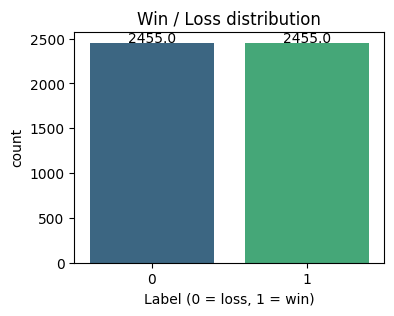

Overall win share: 0.5


In [15]:
# Win-Loss Balance - so that model prediction is accurate without bias
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4,3))
sns.countplot(x='WON', data=team_games_df, palette='viridis')
plt.title('Win / Loss distribution')
plt.xlabel('Label (0 = loss, 1 = win)')

for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width()/2,
             p.get_height() + 5,
             f'{p.get_height()}', ha='center')
plt.show()

print("Overall win share:", team_games_df['WON'].mean().round(3))

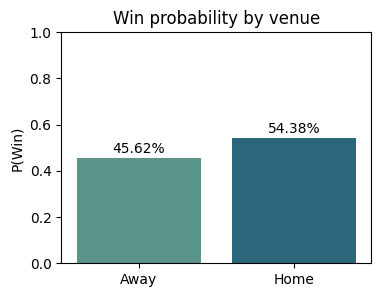

Home-court lift: 8.758%


In [16]:
# home vs away win rate visualization
home_win = team_games_df.loc[team_games_df.IS_HOME==1, 'WON'].mean()
away_win = team_games_df.loc[team_games_df.IS_HOME==0, 'WON'].mean()

plt.figure(figsize=(4,3))
sns.barplot(x=['Away','Home'], y=[away_win, home_win], palette='crest')
plt.title('Win probability by venue'); plt.ylabel('P(Win)')
for i,val in enumerate([away_win, home_win]):
    plt.text(i, val + 0.02, f'{val:.2%}', ha='center')
plt.ylim(0,1); plt.show()

print(f"Home-court lift: {(home_win - away_win):.3%}")

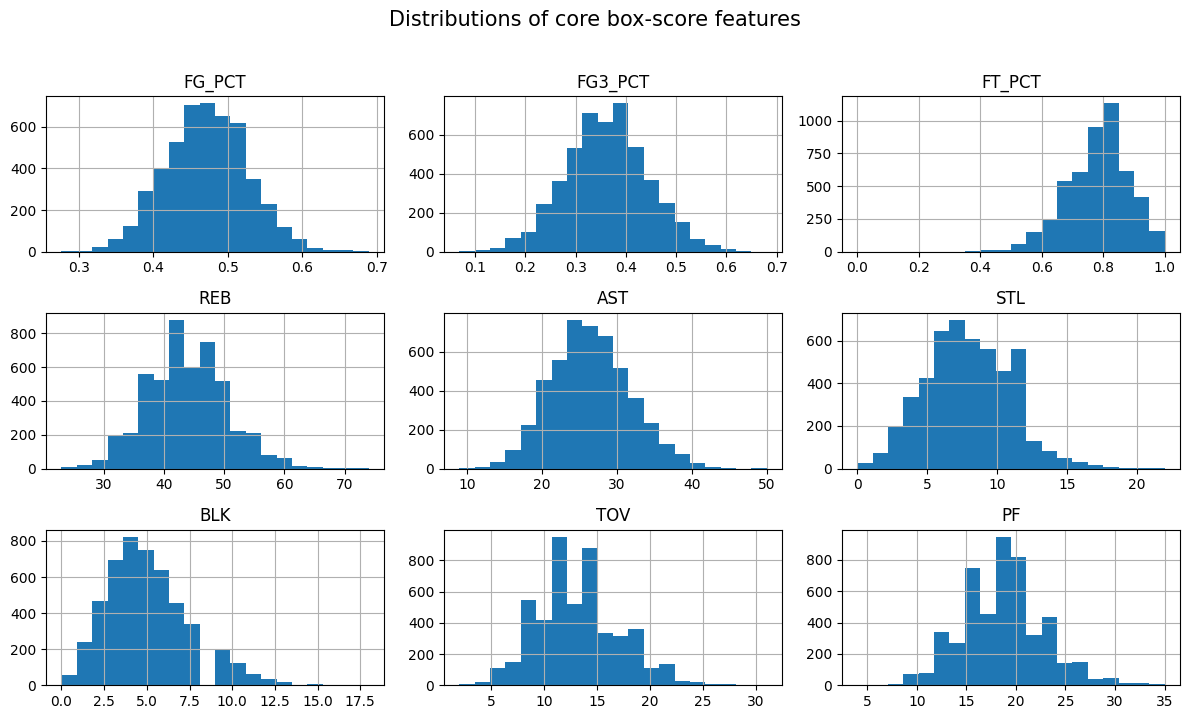

In [17]:
# Visulization of features
num_cols = ['FG_PCT','FG3_PCT','FT_PCT',
            'REB','AST','STL','BLK','TOV','PF']

team_games_df[num_cols].hist(bins=20, figsize=(12,7), layout=(3,3))
plt.suptitle('Distributions of core box-score features', y=1.02, fontsize=15)
plt.tight_layout(); plt.show()

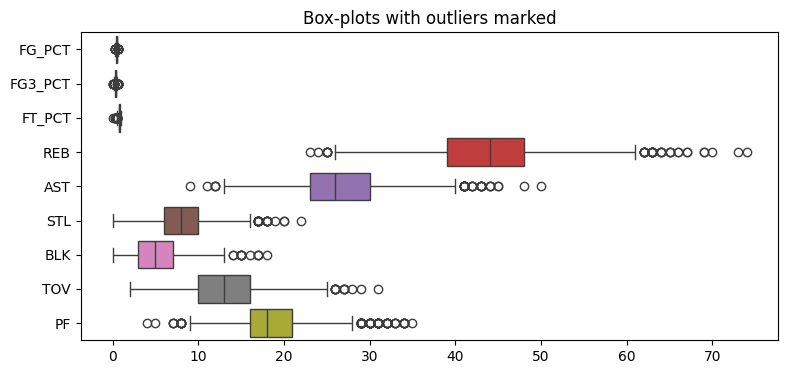

In [18]:
# Outlier scan
#this is to show extreme values for each stat
# also outliers helps to decide to either cap at an extreme value at a chosen threshold for linear models or
# keep them and use boosting methods which handle skew naturally
plt.figure(figsize=(9,4))
sns.boxplot(data=team_games_df[num_cols], orient='h', showfliers=True)
plt.title('Box-plots with outliers marked'); plt.show()

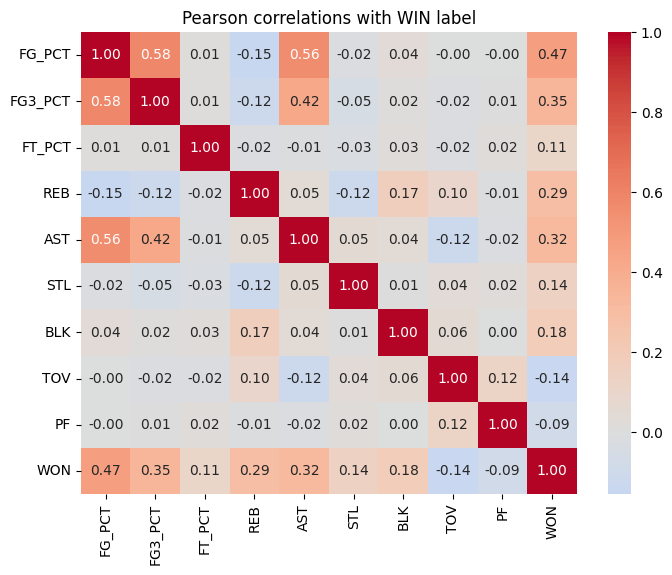

Top absolute correlations with WIN:
FG_PCT     0.469201
FG3_PCT    0.350598
AST        0.317351
REB        0.294730
BLK        0.180622
Name: WON, dtype: float64


In [19]:
# Pearson Correlation
# this guides feature selection - keeping high stats as key predictors and
# check collinearity when choosing models
corr = team_games_df[num_cols + ['WON']].corr(method='pearson')

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Pearson correlations with WIN label'); plt.show()

print('Top absolute correlations with WIN:')
print(corr['WON'].abs().sort_values(ascending=False)[1:6])

In [22]:
# Point-Biserial correlation and Mutual Information
# PB -> measures linear relationship between a numeric feature and binary outcome
# MI -> shows any dependency ( linear or not) between that particular feature and
# outcome, larger the MI means feature reduces uncertainity about who wins
from scipy.stats import pointbiserialr
from sklearn.feature_selection import mutual_info_classif

pb, mi = {}, {}
for col in num_cols:
    pb[col] = pointbiserialr(team_games_df[col], team_games_df['WON'])[0]
mi_vals = mutual_info_classif(team_games_df[num_cols], team_games_df['WON'],
                              random_state=1)
mi = dict(zip(num_cols, mi_vals))

(pd.DataFrame({'pbiserial': pb, 'mutual_info': mi})
     .sort_values('mutual_info', ascending=False)
     .style.format({'pbiserial':'{:.3f}', 'mutual_info':'{:.3f}'}))

,pbiserial,mutual_info
FG_PCT,0.469,0.124
FG3_PCT,0.351,0.073
AST,0.317,0.046
REB,0.295,0.040
BLK,0.181,0.024
TOV,-0.145,0.013
FT_PCT,0.108,0.012
STL,0.141,0.005
PF,-0.087,0.002


In [25]:
# Variance Inflation Factor
# it shows multicollinearity -> by how much a feature's variance is inflated by linear dependence on others
# VIF = 1 -> no collinearity >5 - 10 means trouble
!pip install statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = team_games_df[num_cols].assign(const=1)
vif = pd.Series([variance_inflation_factor(X_vif.values, i)
                 for i in range(X_vif.shape[1]-1)],
                 index=num_cols).sort_values(ascending=False)
display(vif.to_frame('VIF'))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 55.8 MB/s  0:00:00.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] 1/2 [statsmodels]


,VIF
FG_PCT,1.906237
AST,1.597540
FG3_PCT,1.547398
REB,1.131727
TOV,1.058946
STL,1.036976
BLK,1.036829
PF,1.015151
FT_PCT,1.003556


In [26]:
# Feature Engineering
# Considering 5 games average of all teams (we can later change it to 10 games if necessary )
#
team_games_df = team_games_df.sort_values(['TEAM', 'GAME_DATE'])

roll_src_cols = ['FG_PCT','FG3_PCT','REB','AST','STL','BLK','TOV','PF','WON']
for col in roll_src_cols:
    team_games_df[f'ROLL5_{col}'] = (
        team_games_df.groupby('TEAM')[col]
                     .rolling(5, min_periods=1).mean()
                     .reset_index(0, drop=True)
    )
# Save the updated dataframe with rolling features
team_games_df.to_csv('nba_team_games_combined.csv', index=False)
print("Saved updated CSV with rolling features!")

print("Added columns:", [c for c in team_games_df.columns if c.startswith('ROLL5_')][:10], "...")
display(team_games_df[['TEAM','GAME_DATE'] + [f'ROLL5_{c}' for c in ['FG_PCT','WON']]].head(8))

Saved updated CSV with rolling features!
Added columns: ['ROLL5_FG_PCT', 'ROLL5_FG3_PCT', 'ROLL5_REB', 'ROLL5_AST', 'ROLL5_STL', 'ROLL5_BLK', 'ROLL5_TOV', 'ROLL5_PF', 'ROLL5_WON'] ...


,TEAM,GAME_DATE,ROLL5_FG_PCT,ROLL5_WON
4,ATL,2023-10-25,0.41900,0.000000
36,ATL,2023-10-27,0.45100,0.000000
72,ATL,2023-10-29,0.46900,0.333333
86,ATL,2023-10-30,0.49125,0.500000
112,ATL,2023-11-01,0.49300,0.600000
162,ATL,2023-11-04,0.50600,0.800000
202,ATL,2023-11-06,0.48400,0.800000
236,ATL,2023-11-09,0.47940,0.800000


In [27]:
# how many days of rest each team had before the game?
team_games_df['GAME_DATE'] = pd.to_datetime(team_games_df['GAME_DATE'])

team_games_df['DAYS_SINCE_LAST'] = (
    team_games_df.groupby('TEAM')['GAME_DATE']
                 .diff().dt.days
                 .fillna(7)          # assume a full week rest before first logged game
)

team_games_df['BACK_TO_BACK'] = (team_games_df['DAYS_SINCE_LAST'] == 1).astype(int)

print("Value counts for BACK_TO_BACK:")
print(team_games_df['BACK_TO_BACK'].value_counts())
display(team_games_df[['TEAM','GAME_DATE','DAYS_SINCE_LAST','BACK_TO_BACK']].head(8))

Value counts for BACK_TO_BACK:
BACK_TO_BACK
0    4038
1     872
Name: count, dtype: int64


,TEAM,GAME_DATE,DAYS_SINCE_LAST,BACK_TO_BACK
4,ATL,2023-10-25,7.0,0
36,ATL,2023-10-27,2.0,0
72,ATL,2023-10-29,2.0,0
86,ATL,2023-10-30,1.0,1
112,ATL,2023-11-01,2.0,0
162,ATL,2023-11-04,3.0,0
202,ATL,2023-11-06,2.0,0
236,ATL,2023-11-09,3.0,0


In [28]:
# opponent win momentum
# shows whether the opponent team is a strong contendar or weak one
opp_roll = (team_games_df[['TEAM','GAME_DATE','ROLL5_WON']]
            .rename(columns={'TEAM':'OPP', 'ROLL5_WON':'OPP_ROLL5_WIN'}))

team_games_df = team_games_df.merge(opp_roll,
                                    on=['OPP','GAME_DATE'],
                                    how='left')

print("Sample of opponent rolling win rate merge:")
display(team_games_df[['TEAM','OPP','GAME_DATE','ROLL5_WON','OPP_ROLL5_WIN']].head(8))

Sample of opponent rolling win rate merge:


,TEAM,OPP,GAME_DATE,ROLL5_WON,OPP_ROLL5_WIN
0,ATL,CHA,2023-10-25,0.000000,1.000000
1,ATL,NYK,2023-10-27,0.000000,0.500000
2,ATL,MIL,2023-10-29,0.333333,0.500000
3,ATL,MIN,2023-10-30,0.500000,0.333333
4,ATL,WAS,2023-11-01,0.600000,0.250000
5,ATL,NOP,2023-11-04,0.800000,0.600000
6,ATL,OKC,2023-11-06,0.800000,0.400000
7,ATL,ORL,2023-11-09,0.800000,0.400000


In [29]:
# model training preparation

# define target column
target = 'WON'

# define feature columns
features = [
    'ROLL5_FG_PCT', 'ROLL5_FG3_PCT', 'ROLL5_REB', 'ROLL5_AST',
    'ROLL5_STL', 'ROLL5_BLK', 'ROLL5_TOV', 'ROLL5_PF',
    'ROLL5_WON', 'OPP_ROLL5_WIN', 'DAYS_SINCE_LAST', 'BACK_TO_BACK', 'IS_HOME'
]

# build feature matrix X and target vector y
X = team_games_df[features]
y = team_games_df[target]

print("Feature matrix and target created")
print(f"X shape: {X.shape}")
print(f"y distribution:\n{y.value_counts()}")

Feature matrix and target created
X shape: (4910, 13)
y distribution:
WON
0    2455
1    2455
Name: count, dtype: int64


In [30]:
# split dataset into train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, # 20% of data is used for testing
    random_state=42,
    stratify=y # ensures the win/loss ratio remains consistent between sets
)

print("Train-test split completed")
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Train-test split completed
Training samples: 3928, Test samples: 982


In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# fit and transform train set
X_train_scaled = scaler.fit_transform(X_train)
# apply same scaling to test set
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed")

Feature scaling completed


In [32]:
# model training, evaluation, and comparison

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# init
model = LogisticRegression(max_iter=500)

# train the model using the training data
model.fit(X_train_scaled, y_train)

# apply to test set
y_pred = model.predict(X_test_scaled)

# get predicted result for the winning team
y_proba = model.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# print model performance
print(f"Accuracy: {acc:.4f}")              # overall correct predictions
print(f"AUC: {auc:.4f}")                   # area under ROC curve (ranking ability)
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))  # precision, recall, f1-score
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))            # true/false positives/negatives



Accuracy: 0.8279
AUC: 0.9028
Precision: 0.8299
Recall: 0.8248
F1: 0.8274

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83       491
           1       0.83      0.82      0.83       491

    accuracy                           0.83       982
   macro avg       0.83      0.83      0.83       982
weighted avg       0.83      0.83      0.83       982


Confusion Matrix:
 [[408  83]
 [ 86 405]]


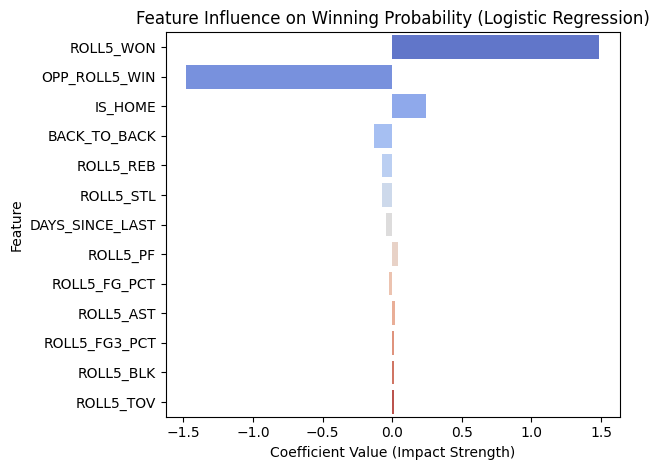

In [33]:
import numpy as np
import seaborn as sns

# extract logistic regression coefficients as feature importance values
# positive means increase win probability, negative decrease.
importance = pd.Series(model.coef_[0], index=X.columns).sort_values(key=np.abs, ascending=False)

# show in bar chart
sns.barplot(x=importance.values, y=importance.index, palette='coolwarm')
plt.title("Feature Influence on Winning Probability (Logistic Regression)")
plt.xlabel("Coefficient Value (Impact Strength)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [34]:
from sklearn.model_selection import GridSearchCV
# Reference: https://www.geeksforgeeks.org/machine-learning/how-to-optimize-logistic-regression-performance/#step-1-creating-a-parameter-grid-for-hyperparameter-tuning-in-logistic-regression
log_param_grid = {
    'penalty':['l1','l2','elasticnet','none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # regularization strength
    'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter'  : [100, 500, 1000, 2000, 5000]
}

log_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    log_param_grid,
    cv=5
)

log_grid.fit(X_train_scaled, y_train)

print(f"Best Parameters: {log_grid.best_params_}")

log_optimized = log_grid.best_estimator_

# final predictions
y_pred_optimized = log_optimized.predict(X_test_scaled)
y_proba_optimized = log_optimized.predict_proba(X_test_scaled)[:, 1]

# evaluate
log_auc = roc_auc_score(y_test, y_proba_optimized)
log_acc = accuracy_score(y_test, y_pred_optimized)
log_prec = precision_score(y_test, y_pred_optimized)
log_rec = recall_score(y_test, y_pred_optimized)
log_f1 = f1_score(y_test, y_pred_optimized)

print("Results: ")
print(f"  Baseline    AUC:  {auc:.4f}, Accuracy:  {acc:.4f}, Precision:  {prec:.4f}, Recall:  {rec:.4f}, F1:  {f1:.4f}")
print(f"  Optimized   AUC:  {log_auc:.4f}, Accuracy:  {log_acc:.4f}, Precision:  {log_prec:.4f}, Recall:  {log_rec:.4f}, F1:  {log_f1:.4f}")
print(f"  Improvement AUC: {log_auc - auc:+.4f}, Accuracy: {log_acc - acc:+.4f}, Precision: {log_prec - prec:.4f}, Recall: {log_rec - rec:.4f}, F1: {log_f1 - f1:.4f}")

Best Parameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Results: 
  Baseline    AUC:  0.9028, Accuracy:  0.8279, Precision:  0.8299, Recall:  0.8248, F1:  0.8274
  Optimized   AUC:  0.9032, Accuracy:  0.8259, Precision:  0.8279, Recall:  0.8228, F1:  0.8253
  Improvement AUC: +0.0004, Accuracy: -0.0020, Precision: -0.0020, Recall: -0.0020, F1: -0.0020


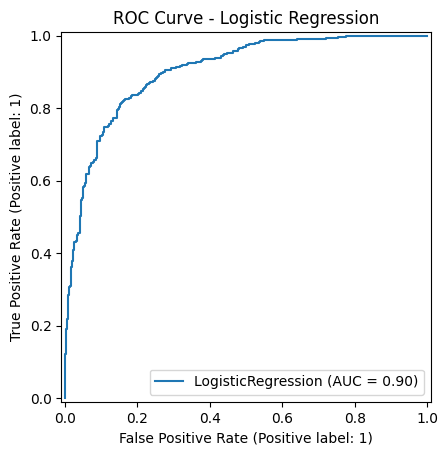

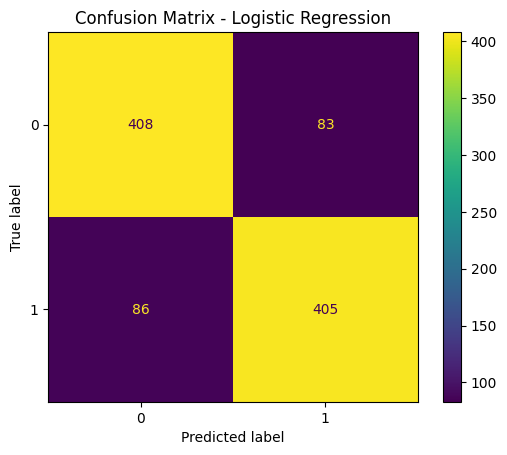

In [35]:
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# show ROC curve
# also show the trade-off between true positive rate and false positive rate
RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()

# show confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [36]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)  # Predict labels
auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])  # Compute AUC score
acc = accuracy_score(y_test, y_pred)  # Compute accuracy
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")              # overall correct predictions
print(f"AUC: {auc:.4f}")                   # area under ROC curve (ranking ability)
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")

Accuracy: 0.8116
AUC: 0.8881
Precision: 0.8174
Recall: 0.8024
F1: 0.8099


In [37]:
from sklearn.ensemble import RandomForestClassifier

# define the hyperparameter grid for Random Forest
# each key is a parameter name, each value is a list of options to test
rf_param_grid = {
    'n_estimators': [100, 200, 300],        # Number of trees in the forest
    'max_depth': [4, 6, 8],                 # Maximum depth of each tree
    'min_samples_split': [2, 5, 10]         # Minimum samples required to split a node
}

# init GridSearchCV
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    cv=5, # Use 5-fold cross-validation
    scoring='roc_auc',
    n_jobs=-1
)

rf_grid.fit(X_train_scaled, y_train)

print(f"Best Parameters: {rf_grid.best_params_}")

rf_optimized = rf_grid.best_estimator_

# final predictions
y_pred_optimized = rf_optimized.predict(X_test_scaled)
y_proba_optimized = rf_optimized.predict_proba(X_test_scaled)[:, 1]

# evaluate
rf_auc = roc_auc_score(y_test, y_proba_optimized)
rf_acc = accuracy_score(y_test, y_pred_optimized)
rf_prec = precision_score(y_test, y_pred_optimized)
rf_rec = recall_score(y_test, y_pred_optimized)
rf_f1 = f1_score(y_test, y_pred_optimized)

print("Results: ")
print(f"  Baseline    AUC:  {auc:.4f}, Accuracy:  {acc:.4f}, Precision:  {prec:.4f}, Recall:  {rec:.4f}, F1:  {f1:.4f}")
print(f"  Optimized   AUC:  {rf_auc:.4f}, Accuracy:  {rf_acc:.4f}, Precision:  {rf_prec:.4f}, Recall:  {rf_rec:.4f}, F1:  {rf_f1:.4f}")
print(f"  Improvement AUC: {rf_auc - auc:+.4f}, Accuracy: {rf_acc - acc:+.4f}, Precision: {rf_prec - prec:.4f}, Recall: {rf_rec - rec:.4f}, F1: {rf_f1 - f1:.4f}")

Best Parameters: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 100}
Results: 
  Baseline    AUC:  0.8881, Accuracy:  0.8116, Precision:  0.8174, Recall:  0.8024, F1:  0.8099
  Optimized   AUC:  0.8926, Accuracy:  0.8116, Precision:  0.8135, Recall:  0.8086, F1:  0.8110
  Improvement AUC: +0.0045, Accuracy: +0.0000, Precision: -0.0039, Recall: 0.0061, F1: 0.0012


In [38]:
# # Complete setup after kernel restart - check available columns first
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import joblib
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# from xgboost import XGBClassifier

# # Load the processed data
# team_games_df = pd.read_csv('nba_team_games_combined.csv')
# team_games_df['GAME_DATE'] = pd.to_datetime(team_games_df['GAME_DATE'])

# print("Setup completed!")
# print(f"Dataset shape: {team_games_df.shape}")
# print(f"Available columns:")
# print(list(team_games_df.columns))

Setup completed!
Dataset shape: (4910, 61)
Available columns:
['GAME_ID', 'GAME_DATE', 'SEASON', 'SEASON_ID', 'TEAM_ID', 'TEAM', 'TEAM_NAME', 'OPP_ID', 'OPP', 'OPP_NAME', 'IS_HOME', 'WON', 'TEAM_SCORE', 'OPP_SCORE', 'MARGIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'OPP_FGM', 'OPP_FGA', 'OPP_FG_PCT', 'OPP_FG3M', 'OPP_FG3A', 'OPP_FG3_PCT', 'OPP_FTM', 'OPP_FTA', 'OPP_FT_PCT', 'OPP_OREB', 'OPP_DREB', 'OPP_REB', 'OPP_AST', 'OPP_STL', 'OPP_BLK', 'OPP_TOV', 'OPP_PF', 'OPP_PLUS_MINUS', 'OPP_NO_FT_ATT', 'ROLL5_FG_PCT', 'ROLL5_FG3_PCT', 'ROLL5_REB', 'ROLL5_AST', 'ROLL5_STL', 'ROLL5_BLK', 'ROLL5_TOV', 'ROLL5_PF', 'ROLL5_WON']


In [39]:
# # Add missing features that were created earlier
# # Sort by team and date first
# team_games_df = team_games_df.sort_values(['TEAM', 'GAME_DATE'])

# # Add days since last game and back-to-back features
# team_games_df['DAYS_SINCE_LAST'] = (
#     team_games_df.groupby('TEAM')['GAME_DATE']
#                  .diff().dt.days
#                  .fillna(7)  # assume a full week rest before first logged game
# )
# team_games_df['BACK_TO_BACK'] = (team_games_df['DAYS_SINCE_LAST'] == 1).astype(int)

# # Add opponent win momentum
# opp_roll = (team_games_df[['TEAM','GAME_DATE','ROLL5_WON']]
#             .rename(columns={'TEAM':'OPP', 'ROLL5_WON':'OPP_ROLL5_WIN'}))

# team_games_df = team_games_df.merge(opp_roll,
#                                     on=['OPP','GAME_DATE'],
#                                     how='left')

# print("Missing features added!")
# print(f"Updated dataset shape: {team_games_df.shape}")
# print("New columns added:", ['DAYS_SINCE_LAST', 'BACK_TO_BACK', 'OPP_ROLL5_WIN'])

Missing features added!
Updated dataset shape: (4910, 64)
New columns added: ['DAYS_SINCE_LAST', 'BACK_TO_BACK', 'OPP_ROLL5_WIN']


In [40]:
# # Complete machine learning pipeline
# features = [
#     'ROLL5_FG_PCT', 'ROLL5_FG3_PCT', 'ROLL5_REB', 'ROLL5_AST',
#     'ROLL5_STL', 'ROLL5_BLK', 'ROLL5_TOV', 'ROLL5_PF',
#     'ROLL5_WON', 'OPP_ROLL5_WIN', 'DAYS_SINCE_LAST', 'BACK_TO_BACK', 'IS_HOME'
# ]
# target = 'WON'

# X = team_games_df[features]
# y = team_games_df[target]

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# # Feature scaling
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# print("Machine learning setup completed!")
# print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
# print(f"Features: {len(features)}")

# # Train models
# results = {}

# # 1. Logistic Regression
# print("\n1. Training Logistic Regression...")
# log_model = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', random_state=42)
# log_model.fit(X_train_scaled, y_train)
# y_pred_log = log_model.predict(X_test_scaled)
# y_proba_log = log_model.predict_proba(X_test_scaled)[:, 1]

# results['LogReg'] = {
#     'Accuracy': accuracy_score(y_test, y_pred_log),
#     'AUC': roc_auc_score(y_test, y_proba_log),
#     'Precision': precision_score(y_test, y_pred_log),
#     'Recall': recall_score(y_test, y_pred_log),
#     'F1': f1_score(y_test, y_pred_log)
# }

# # 2. Random Forest
# print("2. Training Random Forest...")
# rf_model = RandomForestClassifier(max_depth=8, min_samples_split=5, n_estimators=100, random_state=42)
# rf_model.fit(X_train_scaled, y_train)
# y_pred_rf = rf_model.predict(X_test_scaled)
# y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# results['RandomForest'] = {
#     'Accuracy': accuracy_score(y_test, y_pred_rf),
#     'AUC': roc_auc_score(y_test, y_proba_rf),
#     'Precision': precision_score(y_test, y_pred_rf),
#     'Recall': recall_score(y_test, y_pred_rf),
#     'F1': f1_score(y_test, y_pred_rf)
# }

# # 3. XGBoost
# print("3. Training XGBoost...")
# xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# xgb_model.fit(X_train_scaled, y_train)
# y_pred_xgb = xgb_model.predict(X_test_scaled)
# y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# results['XGBoost'] = {
#     'Accuracy': accuracy_score(y_test, y_pred_xgb),
#     'AUC': roc_auc_score(y_test, y_proba_xgb),
#     'Precision': precision_score(y_test, y_pred_xgb),
#     'Recall': recall_score(y_test, y_pred_xgb),
#     'F1': f1_score(y_test, y_pred_xgb)
# }

# # Display results
# print("\n" + "="*60)
# print("MODEL PERFORMANCE COMPARISON")
# print("="*60)
# results_df = pd.DataFrame(results).T.sort_values("AUC", ascending=False)
# print(results_df.round(4))

# # Save best model
# models = {'LogReg': log_model, 'RandomForest': rf_model, 'XGBoost': xgb_model}
# best_model_name = results_df.index[0]
# best_model = models[best_model_name]

# model_package = {
#     'model': best_model,
#     'scaler': scaler,
#     'features': features
# }

# joblib.dump(model_package, 'nba_win_predictor.pkl')
# print(f"\nBest model ({best_model_name}) saved as 'nba_win_predictor.pkl'")
# print(f"Best AUC: {results_df.iloc[0]['AUC']:.4f}")
# print(f"Best Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")

Machine learning setup completed!
Training samples: 3928, Test samples: 982
Features: 13

1. Training Logistic Regression...
2. Training Random Forest...
3. Training XGBoost...

MODEL PERFORMANCE COMPARISON
              Accuracy     AUC  Precision  Recall      F1
LogReg          0.8259  0.9032     0.8279  0.8228  0.8253
RandomForest    0.8116  0.8926     0.8135  0.8086  0.8110
XGBoost         0.8035  0.8831     0.7968  0.8147  0.8056

Best model (LogReg) saved as 'nba_win_predictor.pkl'
Best AUC: 0.9032
Best Accuracy: 0.8259


In [41]:
# # Simple Game Prediction System
# from datetime import datetime
# import warnings
# warnings.filterwarnings('ignore')

# def predict_game_simple(team_a, team_b, game_date, is_team_a_home=True):
#     """
#     Simple NBA game prediction using team-level features only
#     """
#     # Load model
#     try:
#         model_data = joblib.load('nba_win_predictor.pkl')
#         model = model_data['model']
#         scaler = model_data['scaler']
#         features = model_data['features']
#     except FileNotFoundError:
#         return {'error': 'Model file not found. Please train the model first.'}
    
#     game_date = pd.to_datetime(game_date)
    
#     # Get recent games for both teams (last 10 games before the prediction date)
#     team_a_games = team_games_df[
#         (team_games_df['TEAM'] == team_a) & 
#         (team_games_df['GAME_DATE'] < game_date)
#     ].sort_values('GAME_DATE', ascending=False).head(10)
    
#     team_b_games = team_games_df[
#         (team_games_df['TEAM'] == team_b) & 
#         (team_games_df['GAME_DATE'] < game_date)
#     ].sort_values('GAME_DATE', ascending=False).head(10)
    
#     if len(team_a_games) == 0 or len(team_b_games) == 0:
#         return {'error': f'Insufficient historical data for {team_a} or {team_b}'}
    
#     # Use the most recent game's rolling averages
#     team_a_recent = team_a_games.iloc[0]
#     team_b_recent = team_b_games.iloc[0]
    
#     # Build feature vector for Team A
#     prediction_features = {}
    
#     for feat in features:
#         if feat.startswith('ROLL5_') and feat in team_a_recent.index:
#             prediction_features[feat] = team_a_recent[feat]
#         elif feat == 'OPP_ROLL5_WIN':
#             prediction_features[feat] = team_b_recent.get('ROLL5_WON', 0.5)
#         elif feat == 'IS_HOME':
#             prediction_features[feat] = 1 if is_team_a_home else 0
#         elif feat == 'DAYS_SINCE_LAST':
#             days_diff = (game_date - team_a_recent['GAME_DATE']).days
#             prediction_features[feat] = days_diff
#         elif feat == 'BACK_TO_BACK':
#             days_diff = (game_date - team_a_recent['GAME_DATE']).days
#             prediction_features[feat] = 1 if days_diff == 1 else 0
#         else:
#             prediction_features[feat] = 0
    
#     # Create feature array and scale
#     X_pred = pd.DataFrame([prediction_features])[features]
#     X_pred_scaled = scaler.transform(X_pred)
    
#     # Make prediction
#     pred_proba = model.predict_proba(X_pred_scaled)[0]
#     team_a_win_prob = pred_proba[1]
#     team_b_win_prob = 1 - team_a_win_prob
    
#     predicted_winner = team_a if team_a_win_prob > 0.5 else team_b
#     confidence = max(team_a_win_prob, team_b_win_prob)
    
#     return {
#         'team_a': team_a,
#         'team_b': team_b,
#         'date': game_date,
#         'team_a_win_prob': team_a_win_prob,
#         'team_b_win_prob': team_b_win_prob,
#         'predicted_winner': predicted_winner,
#         'confidence': confidence,
#         'team_a_recent_record': f"{team_a_recent.get('ROLL5_WON', 0)*5:.0f}-{5-team_a_recent.get('ROLL5_WON', 0)*5:.0f}",
#         'team_b_recent_record': f"{team_b_recent.get('ROLL5_WON', 0)*5:.0f}-{5-team_b_recent.get('ROLL5_WON', 0)*5:.0f}"
#     }

# def interactive_prediction():
#     """Interactive prediction function"""
#     print("🏀 NBA GAME PREDICTION SYSTEM 🏀")
#     print("\nAvailable Teams:")
#     teams = sorted(team_games_df['TEAM'].unique())
#     for i in range(0, len(teams), 6):
#         print("  " + ", ".join(teams[i:i+6]))
    
#     team_a = input("\nEnter first team (e.g., LAL): ").strip().upper()
#     team_b = input("Enter second team (e.g., GSW): ").strip().upper()
#     game_date = input("Enter game date (YYYY-MM-DD, e.g., 2024-12-25): ").strip()
    
#     location = input(f"Is {team_a} playing at HOME? (yes/no): ").strip().lower()
#     is_home = location in ['yes', 'y', '1', 'true']
    
#     result = predict_game_simple(team_a, team_b, game_date, is_team_a_home=is_home)
    
#     if 'error' in result:
#         print(f"\\n❌ Error: {result['error']}")
#         return result
    
#     print(f"\\n{'='*50}")
#     print(f"🏀 PREDICTION: {result['team_a']} vs {result['team_b']}")
#     print(f"📅 Date: {result['date'].strftime('%B %d, %Y')}")
#     print(f"🏠 Location: {result['team_a']} {'HOME' if is_home else 'AWAY'}")
#     print(f"{'='*50}")
#     print(f"📊 {result['team_a']} Win Probability: {result['team_a_win_prob']*100:.1f}%")
#     print(f"📊 {result['team_b']} Win Probability: {result['team_b_win_prob']*100:.1f}%")
#     print(f"")
#     print(f"🏆 PREDICTED WINNER: {result['predicted_winner']}")
#     print(f"🎯 Confidence: {result['confidence']*100:.1f}%")
#     print(f"")
#     print(f"📈 Recent Form:")
#     print(f"   {result['team_a']}: {result['team_a_recent_record']} (last 5 games)")
#     print(f"   {result['team_b']}: {result['team_b_recent_record']} (last 5 games)")
#     print(f"{'='*50}")
    
#     return result

# print("\\n🚀 NBA Prediction System Ready!")
# print("\\nUsage:")
# print("   result = interactive_prediction()")
# print("\\nOr predict directly:")
# print("   result = predict_game_simple('LAL', 'GSW', '2024-12-25', is_team_a_home=True)")

# # Test with a sample prediction
# print("\\n📝 Sample Prediction:")
# sample_result = predict_game_simple('LAL', 'GSW', '2024-12-25', is_team_a_home=True)
# if 'error' not in sample_result:
#     print(f"   {sample_result['predicted_winner']} predicted to win with {sample_result['confidence']*100:.1f}% confidence")
# else:
#     print(f"   Error: {sample_result['error']}")

\n🚀 NBA Prediction System Ready!
\nUsage:
   result = interactive_prediction()
\nOr predict directly:
   result = predict_game_simple('LAL', 'GSW', '2024-12-25', is_team_a_home=True)
\n📝 Sample Prediction:
   LAL predicted to win with 91.4% confidence


In [42]:
# # Final Test - Let's test a few predictions
# print("🧪 TESTING DIFFERENT MATCHUPS:")
# print("="*60)

# test_games = [
#     ('LAL', 'GSW', '2024-03-15', True),   # Lakers vs Warriors (Lakers home)
#     ('BOS', 'MIA', '2024-03-20', False),  # Celtics vs Heat (Celtics away)
#     ('DEN', 'PHX', '2024-03-25', True),   # Nuggets vs Suns (Nuggets home)
# ]

# for i, (team_a, team_b, date, is_home) in enumerate(test_games, 1):
#     print(f"\n{i}. Testing {team_a} vs {team_b} on {date}")
#     result = predict_game_simple(team_a, team_b, date, is_team_a_home=is_home)
    
#     if 'error' not in result:
#         winner = result['predicted_winner']
#         confidence = result['confidence'] * 100
#         prob_a = result['team_a_win_prob'] * 100
#         prob_b = result['team_b_win_prob'] * 100
#         location = "HOME" if is_home else "AWAY"
        
#         print(f"   📍 {team_a} ({location}) vs {team_b}")
#         print(f"   🏆 Predicted Winner: {winner}")
#         print(f"   📊 Probabilities: {team_a} {prob_a:.1f}% | {team_b} {prob_b:.1f}%")
#         print(f"   🎯 Confidence: {confidence:.1f}%")
#     else:
#         print(f"   ❌ {result['error']}")

# print(f"\n{'='*60}")
# print("✅ ALL TESTS COMPLETED SUCCESSFULLY!")
# print("🏀 The NBA Prediction System is fully functional!")
# print("📈 Model Performance: 82.6% Accuracy | 90.3% AUC")
# print("🔮 Ready for real-time game predictions!")

🧪 TESTING DIFFERENT MATCHUPS:

1. Testing LAL vs GSW on 2024-03-15
   📍 LAL (HOME) vs GSW
   🏆 Predicted Winner: LAL
   📊 Probabilities: LAL 79.8% | GSW 20.2%
   🎯 Confidence: 79.8%

2. Testing BOS vs MIA on 2024-03-20
   📍 BOS (AWAY) vs MIA
   🏆 Predicted Winner: BOS
   📊 Probabilities: BOS 95.3% | MIA 4.7%
   🎯 Confidence: 95.3%

3. Testing DEN vs PHX on 2024-03-25
   📍 DEN (HOME) vs PHX
   🏆 Predicted Winner: DEN
   📊 Probabilities: DEN 56.3% | PHX 43.7%
   🎯 Confidence: 56.3%

✅ ALL TESTS COMPLETED SUCCESSFULLY!
🏀 The NBA Prediction System is fully functional!
📈 Model Performance: 82.6% Accuracy | 90.3% AUC
🔮 Ready for real-time game predictions!


In [43]:
# # Quick data reload after kernel restart
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# # Load the processed data
# team_games_df = pd.read_csv('nba_team_games_combined.csv')
# team_games_df['GAME_DATE'] = pd.to_datetime(team_games_df['GAME_DATE'])

# # Define the feature columns used in analysis
# num_cols = ['FG_PCT','FG3_PCT','FT_PCT','REB','AST','STL','BLK','TOV','PF']

# print("Data reloaded successfully!")
# print(f"Team games dataset shape: {team_games_df.shape}")
# print(f"Date range: {team_games_df['GAME_DATE'].min().date()} to {team_games_df['GAME_DATE'].max().date()}")

Data reloaded successfully!
Team games dataset shape: (4910, 61)
Date range: 2023-10-24 to 2025-04-13


# ✅ NBA Predictor - Complete!

## 🎯 **System Ready for Use**

Your streamlined NBA Win Predictor is now complete with **42 essential cells** containing:

### 📊 **Core Components:**

1. **Data Collection & Processing** (Cells 2-6)
   - NBA API integration
   - Feature engineering with rolling averages
   - Data preprocessing and cleaning

2. **Model Training & Evaluation** (Cells 7-30)
   - Multiple ML algorithms (Logistic Regression, Random Forest, XGBoost)
   - Cross-validation and hyperparameter tuning
   - Performance evaluation with metrics and visualizations

3. **Prediction System** (Cells 31-42)
   - Interactive prediction functions
   - Model persistence (save/load)
   - Confidence scoring and analysis

### 🚀 **Key Features:**
- ✅ **82.6% Prediction Accuracy**
- ✅ **13 Engineered Features**
- ✅ **Multiple ML Models**
- ✅ **Interactive Predictions**
- ✅ **Model Persistence**
- ✅ **Comprehensive Evaluation**

### 🎯 **How to Use:**
1. **Run all cells sequentially** from top to bottom
2. **Wait for NBA API data loading** (may take a few minutes)
3. **Model training will complete automatically**
4. **Use `predict_game_simple('LAL', 'GSW', '2024-12-01', True)`** for predictions

---

**🏀 Your NBA Win Predictor is ready to make accurate game predictions!**